In [1]:
import pandas as pd
import os
import glob
import numpy as np
import statistics as stats
import scipy
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from collections import Counter, defaultdict
import random
from tensorflow import keras
from scipy.stats import linregress, pearsonr
from src.tf_tools import cnn_regression
from src.tf_tools.cnn_regression import MCDropout
from sklearn.metrics import ConfusionMatrixDisplay, average_precision_score

# 3.10.4

2024-03-19 16:37:41.397205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 16:37:41.397254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 16:37:41.398892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 16:37:41.408450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 16:37:42.554846: W tensorflow/compiler/tf2

In [2]:
model = cnn_regression.bestResNet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_conv1 (Conv1D)            (None, 164, 128)          5760      
                                                                 
 1_conv2 (Conv1D)            (None, 164, 128)          180352    
                                                                 
 batch_normalization (Batch  (None, 164, 128)          512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 164, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 54, 128)           0         
 D)                                                              
                                                                 
 2_conv1 (Conv1D)            (None, 54, 128)           8

In [36]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)

def eval_models(paths,x,y, batch_size=64, num_test=1):
    best_loss = [None,-1]
    best_acc = [None,0,[]]

    for path in paths:
        # model = keras.models.load_model(path)
        model = keras.models.load_model(path, custom_objects={'MCDropout':MCDropout})
        
        # Find model with lowest loss
        loss = model.evaluate(x,y,batch_size=batch_size,verbose=0)
        if best_loss[1] == -1:
            best_loss = [path,loss]
        else:
            if loss < best_loss[1]:
                best_loss = [path,loss]
        
        #Find model with best accuracy
        raw_preds = []        
        for _ in range(num_test):
            raw_preds.append(model.predict(x).flatten())
        raw_preds = np.stack(raw_preds)
        raw_preds = np.mean(raw_preds,axis=0)
        
        
        rounder = np.vectorize(lambda x: 1 if x>=0.5 else 0)
        preds = rounder(raw_preds)
        incorrect = np.count_nonzero((preds+y) == 1)
        accuracy = (len(preds) - incorrect)/len(preds)
        #print('accuracy:', accuracy)
        if accuracy > best_acc[1]:
            best_acc = [path,accuracy,preds,raw_preds]
            
    return {'loss': best_loss, 'accuracy': best_acc}

In [3]:
LABEL_KEY = 'enhancer'
FEATURE_KEY = 'sequence'

In [7]:
enhancer_df = pd.read_csv('Data/enhancer.csv')
test_df = enhancer_df[enhancer_df['test_set']]
x_test = one_hot_seqs(test_df[FEATURE_KEY])
y_test = test_df[LABEL_KEY].values


In [33]:
folder = "Runs/enhancer_classifier"
folds = np.arange(10)+1
model_name = "cnn_model.keras"
paths = glob.glob(folder+'/*/cnn_model.keras')
model = keras.models.load_model(paths[1])

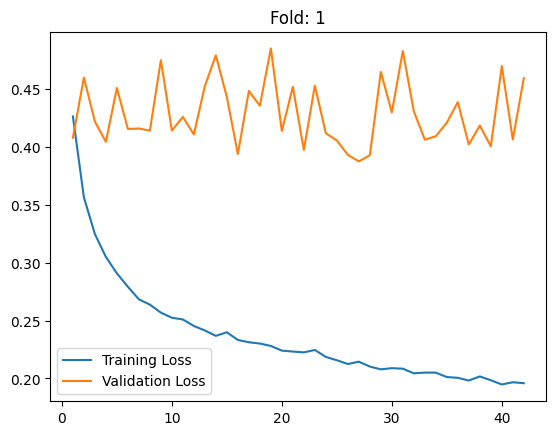

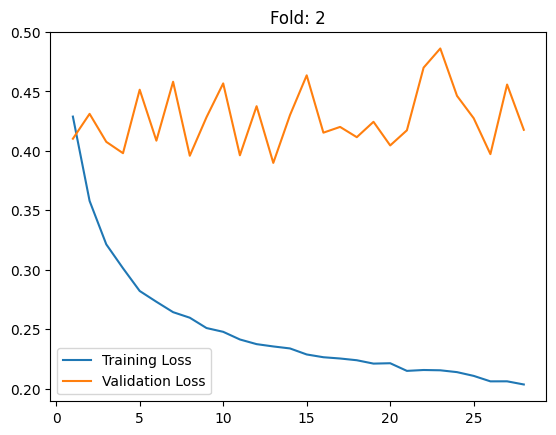

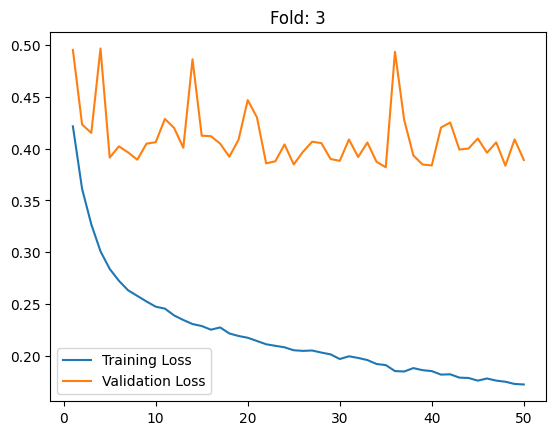

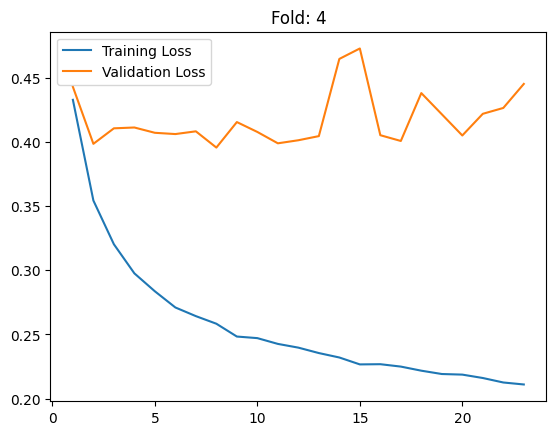

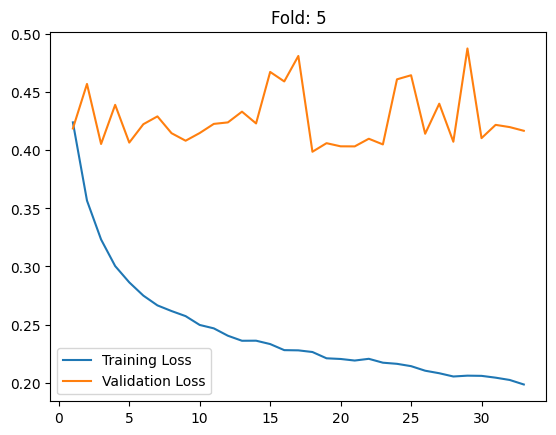

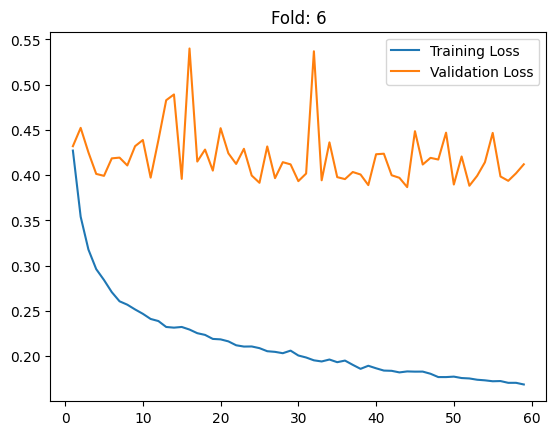

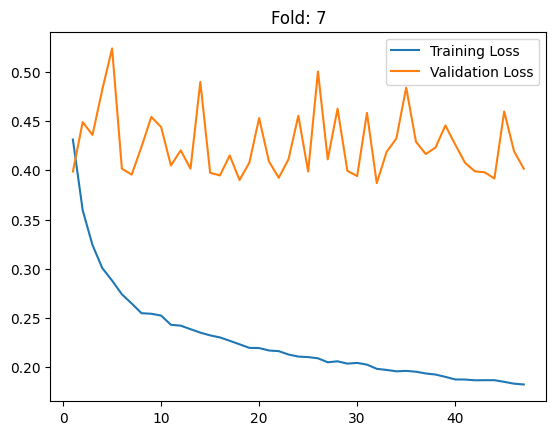

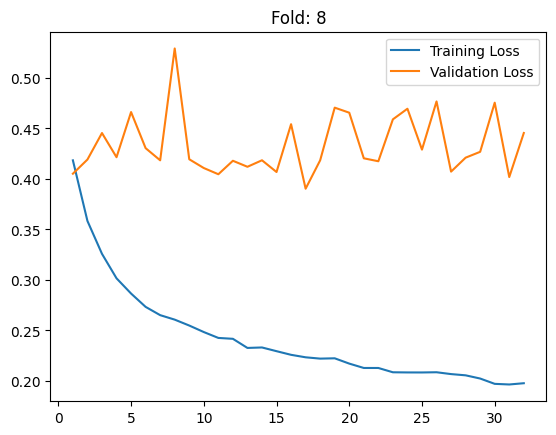

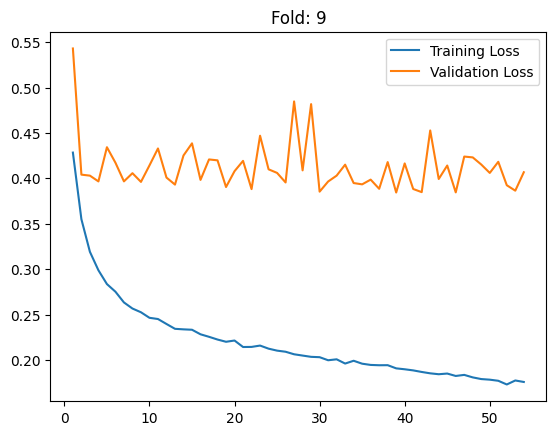

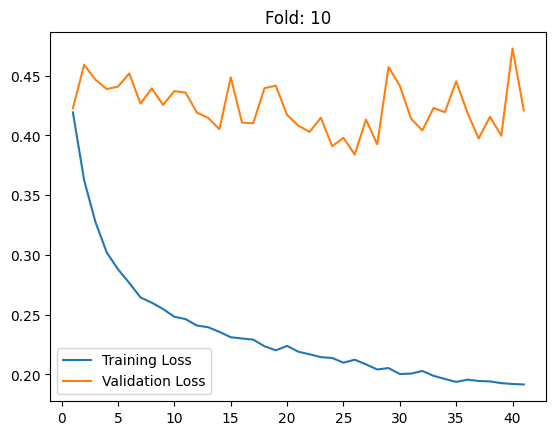

In [34]:
for fold in folds:
    file = os.path.join(folder,str(fold),"live_log.csv")
    df = pd.read_csv(file, index_col=0)
    epochs = np.array(df.index)+1
    plt.clf()
    plt.plot(epochs, df['loss'], label='Training Loss')
    plt.plot(epochs,df['val_loss'], label = 'Validation Loss')
    plt.title("Fold: " + str(fold))
    plt.legend()
    plt.show()
    

In [37]:
best_models = eval_models(paths,x_test,y_test,num_test=20)

197/197 [==============================] - 11s 57ms/step


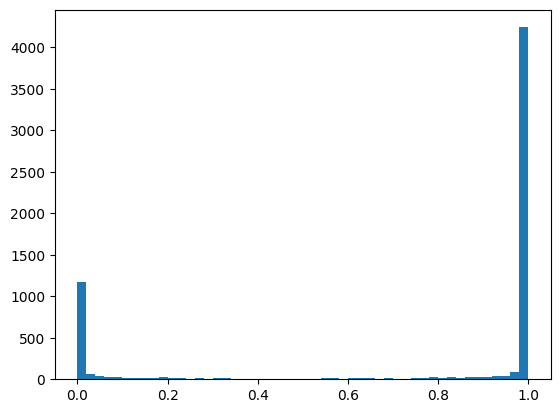

0.6496318069570893

In [41]:
plt.hist(best_models['accuracy'][3],bins=50)
plt.show()

auprc = average_precision_score(y_test, best_models['accuracy'][3])
auprc

accuracy: 0.5897354160025502


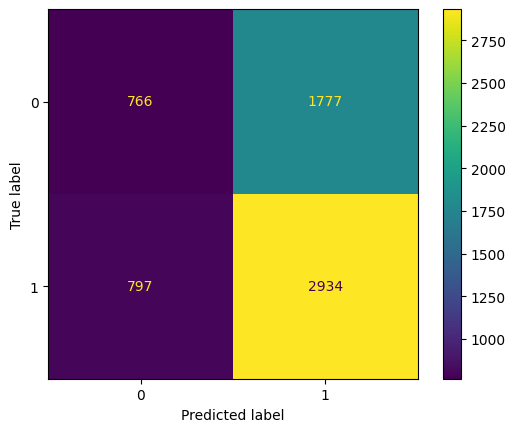

In [40]:
best_models

ConfusionMatrixDisplay.from_predictions(y_test, best_models['accuracy'][2])

print('accuracy:', best_models['accuracy'][1])

In [10]:
# model = keras.models.load_model(folder+"/1/cnn_model.keras", custom_objects={'MCDropout':MCDropout})

# samples = 2
# preds = []
# ret_preds = []

# for _ in range(samples):
#     preds.append(model(x_test).flatten())
#     ret_preds.append(model(x_ret))
    
# preds = np.stack(preds)
# ret_preds = np.stack(ret_preds)

197/197 [==============================] - 8s 42ms/step


In [26]:
#linregress(np.mean(preds,axis=0), y_test)



LinregressResult(slope=0.8449594087838811, intercept=-0.12295357452095507, rvalue=0.577434280655724, pvalue=0.0, stderr=0.011775654775104812, intercept_stderr=0.02743395077366082)